[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MikeS96/cv_dl/blob/main/week4/S4L1_Conv_Torch.ipynb)

## Relevant imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [3]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [29]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

### Laoding the MNIST

In [7]:
input_size  = 28 * 28   # images are 28x28 pixels
output_size = 10        # there are 10 classes

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                          transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                                          ])),
                                          batch_size = 64, shuffle = True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, 
                                          transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                                          ])),
                                          batch_size=1000, shuffle=True)

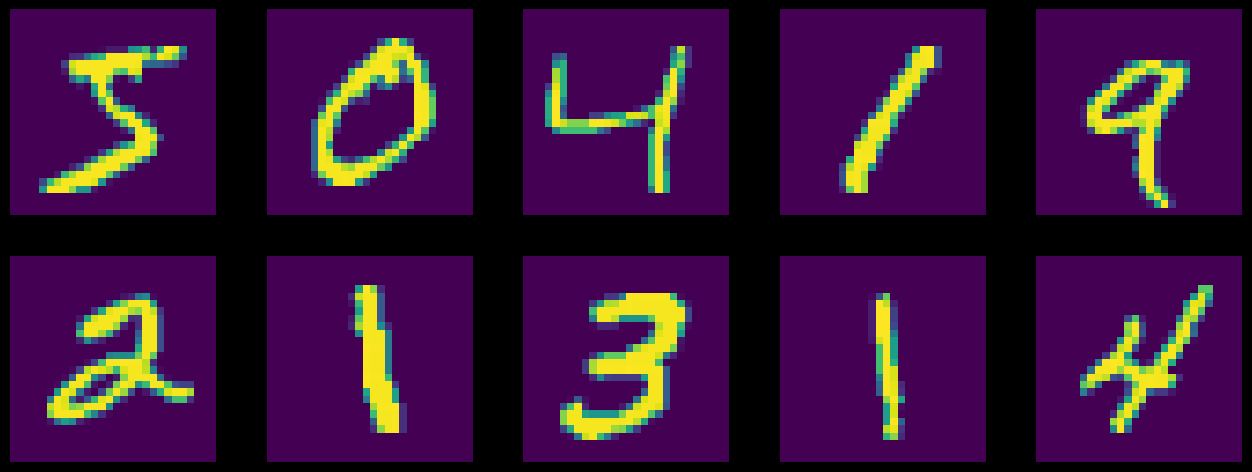

In [30]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

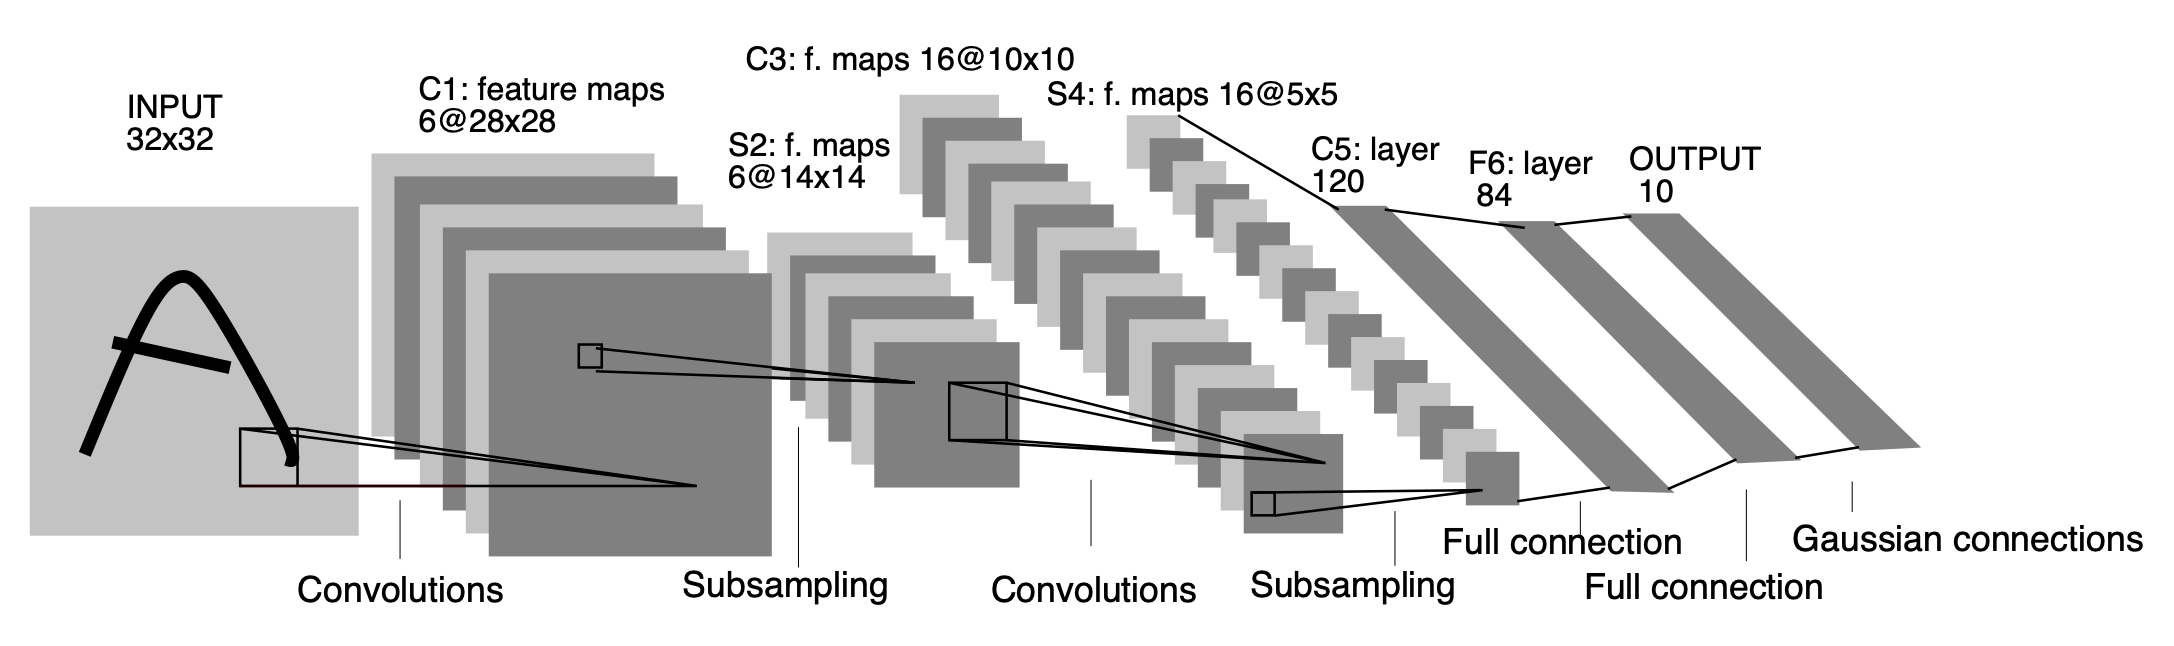

In [9]:
# Creating the model
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0)
    self.fc1 = nn.Linear(in_features = 400, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.output = nn.Linear(in_features = 84, out_features = 10)

  def forward(self, x):
    # Conv1
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    # Conv2
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    # Flatten
    x = x.view(-1, 400)
    # Fullt connected layers
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.output(x)
    # Softmax is applied over rows (batches)
    x = F.log_softmax(x, dim=1)
    return x

model_cnn = LeNet5()
model_cnn.to(device)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
summary(model_cnn, (1, 28, 28))

Number of parameters: 61706
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [14]:
# Model's optimizer
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
# Loss funciton
criterion = nn.NLLLoss()

In [15]:
# number of epochs to train the model
n_epochs = 30
train_on_gpu = True
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model_cnn.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_cnn(data)
        # calculate the batch loss
        # Target has one hot encoding, output is an array of size 10 per sample
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model_cnn.eval()
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_cnn(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model_cnn.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.403682 	Validation Loss: 0.119404
Validation loss decreased (inf --> 0.119404).  Saving model ...
Epoch: 2 	Training Loss: 0.109244 	Validation Loss: 0.074666
Validation loss decreased (0.119404 --> 0.074666).  Saving model ...
Epoch: 3 	Training Loss: 0.078784 	Validation Loss: 0.077412
Epoch: 4 	Training Loss: 0.063642 	Validation Loss: 0.050306
Validation loss decreased (0.074666 --> 0.050306).  Saving model ...
Epoch: 5 	Training Loss: 0.053408 	Validation Loss: 0.048676
Validation loss decreased (0.050306 --> 0.048676).  Saving model ...
Epoch: 6 	Training Loss: 0.045608 	Validation Loss: 0.039940
Validation loss decreased (0.048676 --> 0.039940).  Saving model ...
Epoch: 7 	Training Loss: 0.039777 	Validation Loss: 0.040141
Epoch: 8 	Training Loss: 0.035231 	Validation Loss: 0.034730
Validation loss decreased (0.039940 --> 0.034730).  Saving model ...
Epoch: 9 	Training Loss: 0.031263 	Validation Loss: 0.037966
Epoch: 10 	Training Loss: 0.028631 	Valida

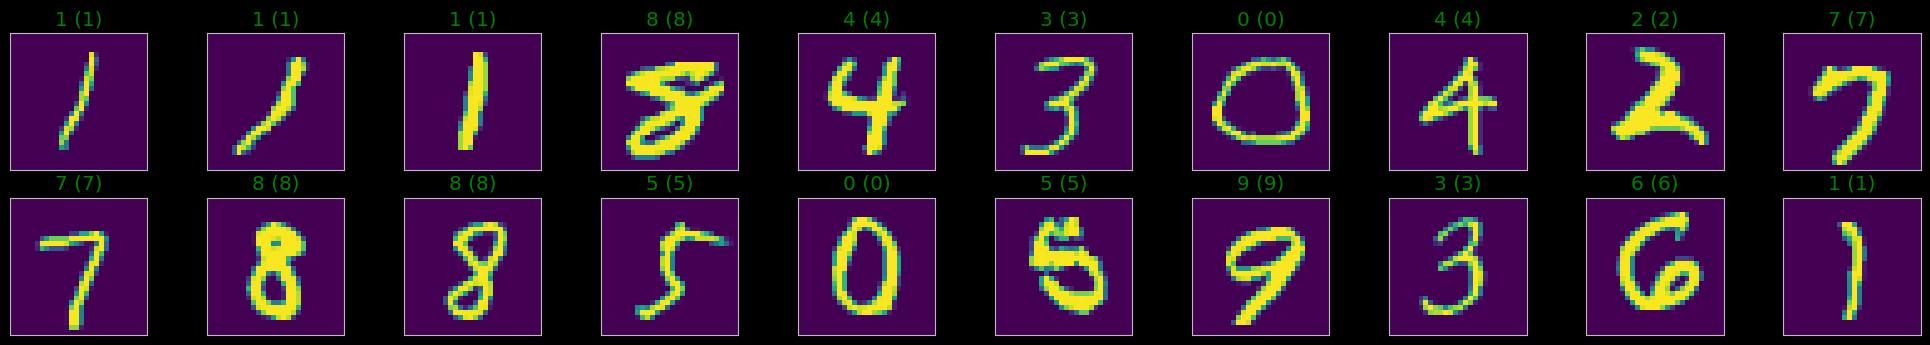

In [32]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()
classes = []

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model_cnn(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images.cpu().squeeze()[idx])
    ax.set_title("{} ({})".format(preds[idx], labels[idx]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))